# Introduction

In this project, we will create a web app for book recommendation using machine learning algorithm.

We will be using the dataset from Kaggle: [Book Recommendation Dataset](https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset?datasetId=1004280)

## Goals
By the end of this project, we will create a web app with the following features:
1. "Similar book" feature
1. "People also read" feature

## Steps
This project will go through
1. Preparing the GitHub repository
1. Data preparation
    1. Data Cleaning
    1. Exploratory Data Analysis (EDA)
    1. Feature engineering
    1. Feature selection
1. Creating the model
    1. Model training
    1. Model assessment
    1. Model serialization (to make the model reusable in the web app)
1. Setting up the web app
    1. Flask
    1. Streamlit
    1. Running and testing the web app (postman)
1. Web app deployment
    1. Heroku
    1. Dockers
    
## Tools

## Sources
1. [Krish Naik's End To End Machine Learning Project Implementation With Dockers,Github Actions And Deployment](https://www.youtube.com/watch?v=MJ1vWb1rGwM)
1. Kaggle
    1. [[Data]Book Recommendation Dataset](https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset?datasetId=1004280)
    1. [[Notebook]Book_Item-Based Collaborative Filtering](https://www.kaggle.com/code/sebnemgurek/book-item-based-collaborative-filtering)
    1. [[Notebook]Book Recommendation System](https://www.kaggle.com/code/fahadmehfoooz/book-recommendation-system)
1. Additional
    1. [Additional: How to Build a Book Recommendation System](https://www.analyticsvidhya.com/blog/2021/06/build-book-recommendation-system-unsupervised-learning-project/)
    1. [Rpubs: PCA and Linear Regression](https://rpubs.com/esobolewska/pcr-step-by-step#:~:text=PCA%20in%20linear%20regression%20has,with%20Partial%20Least%20Squares%20Regression.)
    1. [Stat SE: PCA vs Linear Regression](https://stats.stackexchange.com/questions/410516/using-pca-vs-linear-regression)
    1. [Statology: PCRegression](https://www.statology.org/principal-components-regression-in-python/)

# What Can You Expect In this Notebook?

## Goals
1. Data preparation
1. EDA

## Steps
In this notebook we will do the following:
1. Data cleaning
1. EDA of each dataset
1. Feature engineering
1. Feature selection
    1. "Manual" feature selection
    1. PCA
    1. t-SNE(?)

# Data Preparation

In [54]:
# import libraries (you may add additional imports but you may not have to)
import logging
logging.captureWarnings(True)

import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)
from scipy.sparse import csr_matrix

#viz lib
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns

#to scale the data using z-score
from sklearn.preprocessing import StandardScaler

#Importing PCA
from sklearn.decomposition import PCA

In [286]:
books = pd.read_csv("data/Books.csv")
ratings = pd.read_csv("data/Ratings.csv")
users = pd.read_csv("data/Users.csv")

In [287]:
# def make_clickable(val):
#     return '<a target="_blank" href="{}">Goodreads</a>'.format(val, val)

def show_image(val):
    return '<a href="{}"><img src="{}" width=50></img></a>'.format(val, val)

books.head().style.format({'Image-URL-S': show_image})

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,,http://images.amazon.com/images/P/0195153448.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,,http://images.amazon.com/images/P/0060973129.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.LZZZZZZZ.jpg
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,,http://images.amazon.com/images/P/0374157065.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton & Company,,http://images.amazon.com/images/P/0393045218.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.LZZZZZZZ.jpg


In [252]:
books.describe()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
count,271360,271360,271359,271360,271358,271360,271360,271357
unique,271360,242135,102023,202,16807,271044,271044,271041
top,0195153448,Selected Poems,Agatha Christie,2002,Harlequin,http://images.amazon.com/images/P/185326119X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/185326119X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/225307649X.01.LZZZZZZZ.jpg
freq,1,27,632,13903,7535,2,2,2


In [253]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271359 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


In [254]:
# checking if there are values other than digits in all columns

print("columns with non digit value")

for i in books.columns:
    print(i,books[i].str.isdigit().any())

columns with non digit value
ISBN True
Book-Title True
Book-Author True
Year-Of-Publication True
Publisher True
Image-URL-S False
Image-URL-M False
Image-URL-L False


As seen from the `info` and `isdigit` check, year of publication is in the wrong format.<br>
To do
1. For ease in accessing the columns name, we will rename the column name and use snake format.
1. Fix `year of publication` by converting the format to `int`.
1. Pop `image_url_` columns

In [288]:
# rename the columns name
def col_rename_f(data = books):
    col_rename = {i:i.lower().replace("-","_") for i in data.columns}

    data = data.rename(
        columns = col_rename
    )

    return data

books_clean = books.copy(deep = True)

books_clean = col_rename_f(books_clean)

In [289]:
# list the indexes of weird records

weird_author = books_clean[books_clean["book_author"].str.contains(r'\\') == True]['isbn']
weird_title = books_clean[books_clean["year_of_publication"].str.isdigit()==False].index.tolist()

# there are 3 rows that have a shifted records, fix it here
for i in weird_title:
    for j,k in zip(books_clean.columns[:1:-1].tolist(), range(7,1,-1)):
        books_clean.at[i, books_clean.iloc[i].index[k]] = books_clean.iloc[i][books_clean.columns.get_loc(j) - 1]

for i in weird_title:
    books_clean.at[i,"book_author"] = books_clean.iloc[weird_title]['book_title'].str.split(r'\\', expand = True)[1][i]

# cleaning the author name
books_clean["book_author"] = books_clean["book_author"].replace(
    to_replace = ['"',r'\\'],
    regex=True,
    value = "",
)

# books_clean[books_clean['isbn'].isin(weird_author.values)]

In [290]:
images = books_clean.drop(books_clean.columns[1:5], axis=1)

books_clean = books_clean.drop(books_clean.columns[5:], axis=1)

books_clean["year_of_publication"] = books_clean["year_of_publication"].astype('int')

In [277]:
# drop books with unknown year of publishing (optional)
# books_clean = books_clean[books_clean["year_of_publication"]!=0]

In [7]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [10]:
ratings.describe()

,User-ID,Book-Rating
count,1.149780e+06,1.149780e+06
mean,1.403864e+05,2.866950e+00
std,8.056228e+04,3.854184e+00
min,2.000000e+00,0.000000e+00
25%,7.034500e+04,0.000000e+00
50%,1.410100e+05,0.000000e+00
75%,2.110280e+05,7.000000e+00
max,2.788540e+05,1.000000e+01


In [292]:
ratings_clean = ratings.copy(deep = True)
ratings_clean = col_rename_f(ratings_clean)

<AxesSubplot:xlabel='book_rating', ylabel='count'>

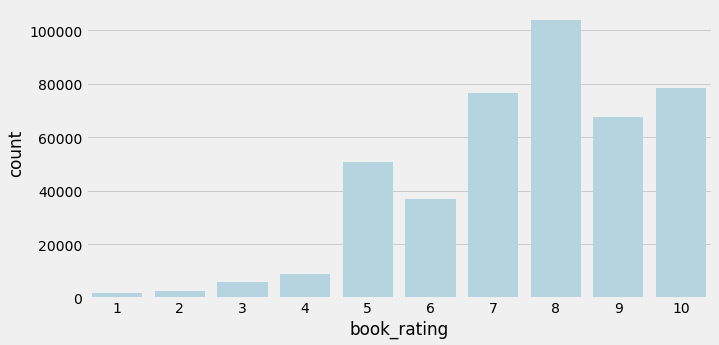

In [349]:
fig, ax = plt.subplots(figsize = (10,5))

sns.countplot(
    ratings_clean[ratings_clean['book_rating']!=0]['book_rating'],
    color = 'lightblue'
)

In [313]:
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [11]:
users.describe()

,User-ID,Age
count,278858.00000,168096.000000
mean,139429.50000,34.751434
std,80499.51502,14.428097
min,1.00000,0.000000
25%,69715.25000,24.000000
50%,139429.50000,32.000000
75%,209143.75000,44.000000
max,278858.00000,244.000000


In [293]:
users_clean = users.copy(deep = True)
users_clean = col_rename_f(users_clean)

In [344]:
temp = users_clean.copy()
loc_temp = temp['location'].str.split(",",expand = True)

def f(x):
    if x.last_valid_index() is None:
        return np.nan
    else:
        return x[x.last_valid_index()]

temp['country'] = loc_temp.apply(f, axis=1)

,user_id,location,age,country
0,1,"nyc, new york, usa",24.0,usa
1,2,"stockton, california, usa",18.0,usa
2,3,"moscow, yukon territory, russia",24.0,russia
3,4,"porto, v.n.gaia, portugal",17.0,portugal
4,5,"farnborough, hants, united kingdom",24.0,united kingdom
...,...,...,...,...
278853,278854,"portland, oregon, usa",24.0,usa
278854,278855,"tacoma, washington, united kingdom",50.0,united kingdom
278855,278856,"brampton, ontario, canada",24.0,canada
278856,278857,"knoxville, tennessee, usa",24.0,usa


In [331]:
users_clean['age'].fillna(users_clean['age'].mode()[0], inplace = True)

In [332]:
users_clean.head()

,user_id,location,age
0,1,"nyc, new york, usa",24.0
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",24.0
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",24.0


<AxesSubplot:xlabel='age'>

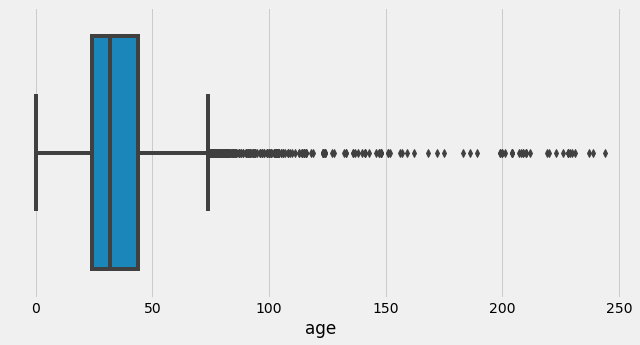

In [312]:
fig, ax = plt.subplots(figsize = (10,5))

sns.boxplot(
    users_clean['age']
)

In [295]:
df1=books_clean.merge(ratings_clean,how="left", on="isbn")
df_=df1.merge(users_clean,how="left", on="user_id")

df=df_.copy()
df.head()

,isbn,book_title,book_author,year_of_publication,publisher,user_id,book_rating,location,age
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,2.0,0.0,"stockton, california, usa",18.0
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,8.0,5.0,"timmins, ontario, canada",NaN
2,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,11400.0,0.0,"ottawa, ontario, canada",49.0
3,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,11676.0,8.0,"n/a, n/a, n/a",NaN
4,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,41385.0,0.0,"sudbury, ontario, canada",NaN


In [297]:
# remove null value
df.dropna(inplace=True)

# Converting User-ID and Age variable types to int
df['user_id'] = df['user_id'].astype('int')
df['age'] = df['age'].astype('int')

# standardize the writing style
df['book_title'] = df['book_title'].str.title()
df['book_author'] = df['book_author'].str.title()

#Removing books with zero ratings from the data set
df=df[df["book_rating"]>0]

In [303]:
df.head()

,isbn,book_title,book_author,year_of_publication,publisher,user_id,book_rating,location,age
5,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,67544,8.0,"toronto, ontario, canada",30
13,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,219008,7.0,"halifax, nova scotia, canada",60
14,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,263325,6.0,"fredericton, new brunswick, canada",27
16,0060973129,Decision In Normandy,Carlo D'Este,1991,HarperPerennial,2954,8.0,"wichita, kansas, usa",71
17,0060973129,Decision In Normandy,Carlo D'Este,1991,HarperPerennial,152827,7.0,"ottawa, ontario, canada",40


## Advice from freeCodeCamp
https://www.freecodecamp.org/learn/machine-learning-with-python/machine-learning-with-python-projects/book-recommendation-engine-using-knn<br>
If you graph the dataset (optional), you will notice that most books are not rated frequently. To ensure statistical significance, remove from the dataset users with less than 200 ratings and books with less than 100 ratings.

In [301]:
# Find how many books have each users read
user_stat = pd.pivot_table(
    data = df,
    values = 'book_title',
    index = 'user_id',
    aggfunc= 'count'
).reset_index()

,user_id,book_title
0,19,1
1,42,1
2,44,1
3,51,1
4,56,2
...,...,...
40538,278844,2
40539,278846,1
40540,278849,1
40541,278851,14
